In [32]:
import numpy as np
import pandas as pd
from actsnfink import *
from myutils import loop_utils as lu
from myutils import plot_utils as pu
from astropy.time import Time, TimeDelta


# Initial configuration

In [33]:
retrain_all_models = False
strategy = 'UncSampling'            # query strategy

In [34]:
# read train and test data
initial_train_for_loop = pd.read_csv( '../data/initial_state/' + strategy + \
                                           '/training_samples/train_after_loop.csv', 
                                           index_col=False)

test_for_loop = pd.read_csv('../data/initial_state/' + strategy + \
                                           '/test_samples/test_after_loop.csv', 
                                           index_col=False)

# select subset of test: only SNe
test_for_loop['type'].unique()
type_list = ['SN','SNII','Ia', 'SLSN-I','SNIIP', 'SNIIn', 'SLSN-II', 'SNIc', 'SNIb', 'SNIIb', 'SNI','SNIb-pec', 'SNIc-BL','SNII-pec','SNIbn']
test_for_loop = test_for_loop[test_for_loop['type'].isin(type_list)]

In [35]:
if retrain_all_models:
    lu.train_and_test_initial_model(initial_train_for_loop,test_for_loop,strategy)

# Fink Siding Spring Observatory follow-up 

In [36]:
# labels from 2.3m SSO, Australia
# here I used the date one day after it was sent to make sure to include all points regardless
# of when the night started

new_labels = {}
new_labels['20230924'] = np.array([['ZTF23abecphw', 'other', Time('2023-09-25', format='iso').jd]]) 
new_labels['20230925'] = np.array([['ZTF23abdhvou', 'Ia', Time('2023-09-26', format='iso').jd]])
new_labels['20230926'] = np.array([['ZTF23abceaws', 'other', Time('2023-09-27', format='iso').jd]])
new_labels['20230929'] = np.array([['ZTF23abeudve', 'Ia', Time('2023-09-30', format='iso').jd],
                                   ['ZTF23abggbdy', 'Ia', Time('2023-09-30', format='iso').jd]])
new_labels['20231005'] = np.array([['ZTF23abhtkba', 'other', Time('2023-10-06', format='iso').jd],
                                  ['ZTF23abglsmj', 'Ia', Time('2023-10-06', format='iso').jd]])
new_labels['20231006'] = np.array([['ZTF23abghfyg', 'Ia', Time('2023-10-07', format='iso').jd],
                                  ['ZTF23abgfwhj', 'Ia', Time('2023-10-07', format='iso').jd],
                                  ['ZTF23abhafym', 'Ia', Time('2023-10-07', format='iso').jd]])
new_labels['20231009'] = np.array([['ZTF23abgspys', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abhublj', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abgnfdv', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abhzwll', 'Ia', Time('2023-10-10', format='iso').jd],
                                   ['ZTF23abhailb', 'other', Time('2023-10-10', format='iso').jd],])
new_labels['20231013'] = np.array([['ZTF23abgspvs', 'Ia', Time('2023-10-14', format='iso').jd]])
new_labels['20231015'] = np.array([ ['ZTF23abihzbq', 'Ia', Time('2023-10-16', format='iso').jd],
                                  ['ZTF23abidsaw', 'Ia', Time('2023-10-16', format='iso').jd],
                                  ['ZTF23abhzlbh', 'Ia', Time('2023-10-16', format='iso').jd],
                                   ['ZTF23abhzoyw', 'Ia', Time('2023-10-16', format='iso').jd],
                                   ['ZTF23abiljba', 'Ia', Time('2023-10-16', format='iso').jd],
                                   ['ZTF23abhzwhl', 'Ia', Time('2023-10-16', format='iso').jd]])
new_labels['20231018'] = np.array([['ZTF23abhvsbo', 'Ia', Time('2023-10-19', format='iso').jd],
                                   ['ZTF23abixwfv', 'other', Time('2023-10-19', format='iso').jd],
                                  ['ZTF23abjhbcr', 'other', Time('2023-10-19', format='iso').jd]])
new_labels['20231019'] = np.array([['ZTF23abkavcl', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abjzkqu', 'Ia', Time('2023-10-20', format='iso').jd],
                                   ['ZTF23abkgdei', 'Ia', Time('2023-10-20', format='iso').jd]])
new_labels['20231022'] = np.array([['ZTF23abjtozz', 'Ia', Time('2023-10-23', format='iso').jd]])
# break
new_labels['20240224'] = np.array([['ZTF24aaejkyp', 'other', Time('2024-02-25', format='iso').jd]])
new_labels['20240229'] = np.array([['ZTF24aaegskb', 'Ia', Time('2024-03-01', format='iso').jd]])
new_labels['20240404'] = np.array([['ZTF24aahgtjt', 'Ia', Time('2024-04-05', format='iso').jd]])
new_labels['20240405'] = np.array([['ZTF24aahgqwk', 'other', Time('2024-04-06', format='iso').jd]])
new_labels['20240409'] = np.array([['ZTF24aahznij', 'Ia', Time('2024-04-10', format='iso').jd],
                                  ['ZTF24aahuulq', 'Ia', Time('2024-04-10', format='iso').jd]])
new_labels['20240410'] = np.array([['ZTF24aaiftcp', 'Ia', Time('2024-04-11', format='iso').jd],
                                  ['ZTF24aaiehwu', 'Ia', Time('2024-04-11', format='iso').jd]])
new_labels['20240412'] = np.array([['ZTF24aaindpx', 'Ia', Time('2024-04-13', format='iso').jd]])
new_labels['20240413'] = np.array([['ZTF24aaiypmp', 'Ia', Time('2024-04-14', format='iso').jd]])
new_labels['20240414'] = np.array([['ZTF24aahtdhb', 'other', Time('2024-04-15', format='iso').jd]]) 
new_labels['20240417'] = np.array([['ZTF24aaieino', 'Ia', Time('2024-04-18', format='iso').jd],])
new_labels['20240418'] = np.array([['ZTF24aaiigrt', 'Ia', Time('2024-04-21', format='iso').jd],
                                  ['ZTF24aaiafkl', 'other', Time('2024-04-19', format='iso').jd]])
new_labels['20240421'] = np.array([['ZTF24aaikjjk', 'other', Time('2024-04-22', format='iso').jd]])
new_labels['20240423'] = np.array([['ZTF24aajqamj', 'other', Time('2024-04-24', format='iso').jd]])
new_labels['20240503'] = np.array([['ZTF24aajwajo', 'other', Time('2024-05-04', format='iso').jd],
                                  ['ZTF24aajqwsm', 'Ia', Time('2024-05-04', format='iso').jd],
                                  ['ZTF24aakwvbi', 'Ia', Time('2024-05-04', format='iso').jd]])
new_labels['20240504'] = np.array([['ZTF24aakfchb', 'other', Time('2024-05-05', format='iso').jd]])
new_labels['20240505'] = np.array([['ZTF24aakymro', 'Ia', Time('2024-05-06', format='iso').jd],
                                   ['ZTF24aajvldc', 'Ia', Time('2024-05-06', format='iso').jd]])
new_labels['20240507'] = np.array([['ZTF24aalhjeu', 'other', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalhjml', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalsuwb', 'Ia', Time('2024-05-08', format='iso').jd],
                                  ['ZTF24aalcflg', 'Ia', Time('2024-05-08', format='iso').jd],
                                   ['ZTF24aalpgky', 'other', Time('2024-05-08', format='iso').jd]])
new_labels['20240508'] = np.array([['ZTF24aakyqxt', 'Ia', Time('2024-05-09', format='iso').jd],
                                   ['ZTF24aalbzkr', 'Ia', Time('2024-05-09', format='iso').jd]])
new_labels['20240510'] = np.array([['ZTF24aalbkdo', 'Ia', Time('2024-05-11', format='iso').jd]])
new_labels['20240514'] = np.array([['ZTF24aamtsgz', 'Ia', Time('2024-05-15', format='iso').jd]])
new_labels['20240515'] = np.array([['ZTF24aamdfll', 'Ia', Time('2024-05-16', format='iso').jd]])
new_labels['20240521'] = np.array([['ZTF24aaomuhe', 'Ia', Time('2024-05-22', format='iso').jd]])
new_labels['20240601'] = np.array([['ZTF24aaoxbth', 'Ia', Time('2024-06-02', format='iso').jd]])
new_labels['20240622'] = np.array([['ZTF24aarfccy', 'Ia', Time('2024-06-23', format='iso').jd],
                                   ['ZTF24aarqrkn', 'Ia', Time('2024-06-23', format='iso').jd]])
new_labels['20240624'] = np.array([['ZTF24aasfxgh', 'Ia', Time('2024-06-25', format='iso').jd]])
new_labels['20240627'] = np.array([['ZTF24aaqutdf', 'other', Time('2024-06-28', format='iso').jd],
                                   ['ZTF24aarwwnc', 'other', Time('2024-06-24', format='iso').jd]])
new_labels['20240628'] = np.array([['ZTF24aasmghi', 'Ia', Time('2024-06-29', format='iso').jd]])
new_labels['20240629'] = np.array([['ZTF24aasqcng', 'other', Time('2024-06-30', format='iso').jd]])
new_labels['20240703'] = np.array([['ZTF24aatkrrw', 'other', Time('2024-07-04', format='iso').jd]])
new_labels['20240706'] = np.array([['ZTF24aatfxrw', 'Ia', Time('2024-07-07', format='iso').jd]])
new_labels['20240708'] = np.array([['ZTF24aatqolq', 'other', Time('2024-07-09', format='iso').jd]])
new_labels['20240709'] = np.array([['ZTF24aatccmo', 'Ia', Time('2024-07-10', format='iso').jd]])
new_labels['20240711'] = np.array([['ZTF24aatyini', 'Ia', Time('2024-07-12', format='iso').jd]])
new_labels['20240719'] = np.array([['ZTF24aavttjp', 'other', Time('2024-07-20', format='iso').jd],
                                   ['ZTF24aaudlat', 'Ia', Time('2024-07-20', format='iso').jd]])
new_labels['20240720'] = np.array([['ZTF24aavovrp', 'Ia', Time('2024-07-21', format='iso').jd]])
new_labels['20240722'] = np.array([['ZTF24aavzglr','Ia', Time('2024-07-23', format='iso').jd]])
new_labels['20240724'] = np.array([['ZTF24aawjctx', 'Ia', Time('2024-07-25', format='iso').jd],
                                  ['ZTF24aavapoe', 'Ia', Time('2024-07-25', format='iso').jd]])
new_labels['20240729'] = np.array([['ZTF24aawrofs','Ia', Time('2024-07-30', format='iso').jd]])
new_labels['20240731'] = np.array([['ZTF24aaxmalj','Ia', Time('2024-08-01', format='iso').jd]])
new_labels['20240804'] = np.array([['ZTF24aaxmpyh','other', Time('2024-08-05', format='iso').jd]])
new_labels['20240805'] = np.array([['ZTF24aawxqj','Ia', Time('2024-08-06', format='iso').jd]])
new_labels['20240806'] = np.array([['ZTF24aaxmacd','Ia', Time('2024-08-07', format='iso').jd],
                                   ['ZTF24aaxmnqo','Ia', Time('2024-08-07', format='iso').jd]
                                  ])
# labels still to be added
new_labels['20240806'] = np.array([['ZTF24aawzlfb','other', Time('2024-08-07', format='iso').jd]])
new_labels['20240807'] = np.array([['ZTF24aaxmpne','Ia', Time('2024-08-08', format='iso').jd]])
new_labels['20240808'] = np.array([['ZTF24aaxqnbe','other', Time('2024-08-09', format='iso').jd],
                                  ['ZTF24aaygegk','Ia', Time('2024-08-09', format='iso').jd]])
new_labels['20240811'] = np.array([['ZTF24aaymouy','Ia', Time('2024-08-12', format='iso').jd]])
new_labels['20240812'] = np.array([['ZTF24aaxzjdt','Ia', Time('2024-08-13', format='iso').jd],
                                   ['ZTF24abakgyn','Ia', Time('2024-08-13', format='iso').jd],
                                   ['ZTF24aayyqub','Ia', Time('2024-08-13', format='iso').jd]])
new_labels['20240813'] = np.array([['ZTF24aazkvzi','Ia', Time('2024-08-14', format='iso').jd]])



In [37]:
if retrain_all_models:
    metrics_fink_all = lu.AL_loop(new_labels,strategy, test_for_loop, dir_suffix ="", proba_cut = False, plot_lcs=True,verbose=False)
else:
    metrics_fink_all =lu.read_previous_metrics('../data/',strategy) 
    

Read 55 metrics


# Fink Siding Spring Observatory follow-up + probability cut

In [38]:
if retrain_all_models:
    metrics_fink_probacut = lu.AL_loop(new_labels, strategy, test_for_loop, dir_suffix='probacut', proba_cut = True,verbose=False,plot_lcs=True)
else:
    metrics_fink_probacut =lu.read_previous_metrics('../data_probacut/',strategy) 

Read 15 metrics


# Non-Fink follow-up

Obtained from TNS

In [39]:
# Function to convert Time object to desired format
def add_days_and_format(x,days):
    # Convert Time object to datetime
    time_obj = Time(x, format='iso') + TimeDelta(days, format='jd')
    dt = time_obj.datetime 
    # dt = time_obj.datetime
    # Format datetime to custom format
    return f"{dt.year}{dt.month:02d}{dt.day:02d}"

In [40]:
# read TNS labels
df_tns_w_ztfdata = du.load_TNS_Fink('../tns/tns_fink_20230817.parquet')


All TNS 16778, from 21 September 2023 on 1804


In [45]:
# classified by ZTF
ztf_tns = df_tns_w_ztfdata[df_tns_w_ztfdata['reporting_group']=='ZTF']
print(f"ZTF detected and spectroscopically classified {len(ztf_tns)}")
dic_ztf_labels = lu.convert_DF_dic_labels(ztf_tns)


ZTF detected and spectroscopically classified 243


In [46]:
if retrain_all_models:
    metrics_ztf = lu.AL_loop(dic_ztf_labels, strategy, test_for_loop, dir_suffix='ZTF', proba_cut = False,verbose=False)
else:
    metrics_ztf =lu.read_previous_metrics('../data_ZTF/',strategy) 


Read 39 metrics


In [47]:
if retrain_all_models:
    metrics_ztf_probacut = lu.AL_loop(dic_ztf_labels, strategy, test_for_loop, dir_suffix='ZTF_probacut', proba_cut = True,verbose=False)
else:
    metrics_ztf_probacut =lu.read_previous_metrics('../data_ZTF_probacut/',strategy) 


Read 12 metrics


### all labels in literature with ZTF data


In [48]:
dic_allTNS_labels = lu.convert_DF_dic_labels(tns_class_ztf_lc)

In [49]:
if retrain_all_models:
    metrics_allTNS = lu.AL_loop(dic_allTNS_labels, strategy, test_for_loop, dir_suffix='allTNS', proba_cut = False,verbose=False)
else:
    metrics_allTNS =lu.read_previous_metrics('../data_allTNS/',strategy) 


Read 39 metrics


### Analysis

In [54]:
# date reformatting to align with all dates in our metrics
all_dates = np.concat([metrics_ztf['date'].values,metrics_fink_all['date'].values,metrics_allTNS['date'].values])
all_dates.sort()

# lets put the date_plot in the same baseline using the combining dataset
# mapping
if "date_plot_universal" not in metrics_fink_all.keys():
    to_merge = pd.DataFrame({'date':all_dates, 'date_plot_universal':np.arange(0,len(all_dates))})
    metrics_fink_all = pd.merge(metrics_fink_all, to_merge, on='date',how='left')
    metrics_fink_probacut = pd.merge(metrics_fink_probacut, to_merge, on='date',how='left')
    metrics_ztf = pd.merge(metrics_ztf, to_merge, on='date',how='left')
    metrics_ztf_probacut = pd.merge(metrics_ztf_probacut, to_merge, on='date',how='left')
    metrics_allTNS = pd.merge(metrics_allTNS, to_merge, on='date',how='left')

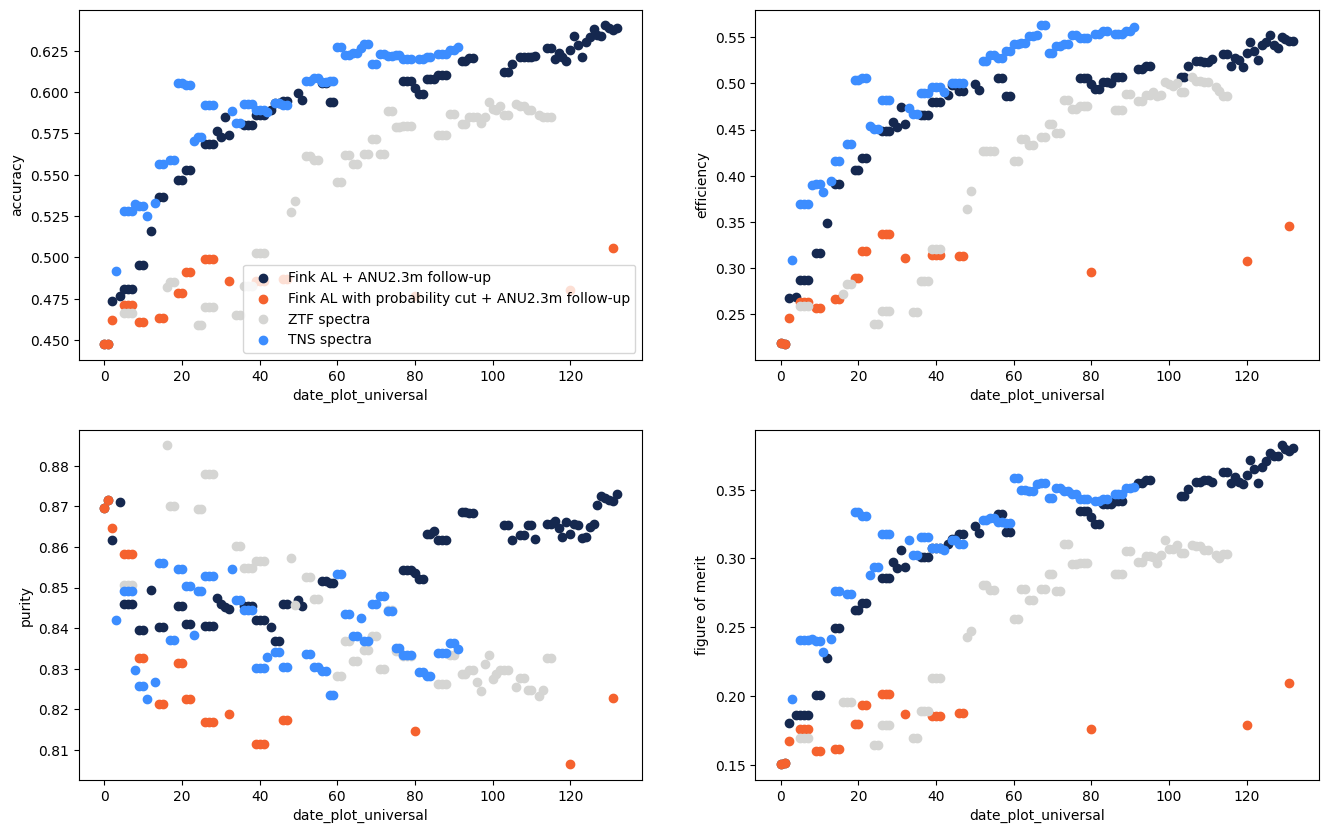

In [55]:
# not completely true as ZTF spectra dates are different than Fink AL ones
pu.plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf,metrics_allTNS],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra', 'TNS spectra'],varx='date_plot_universal')

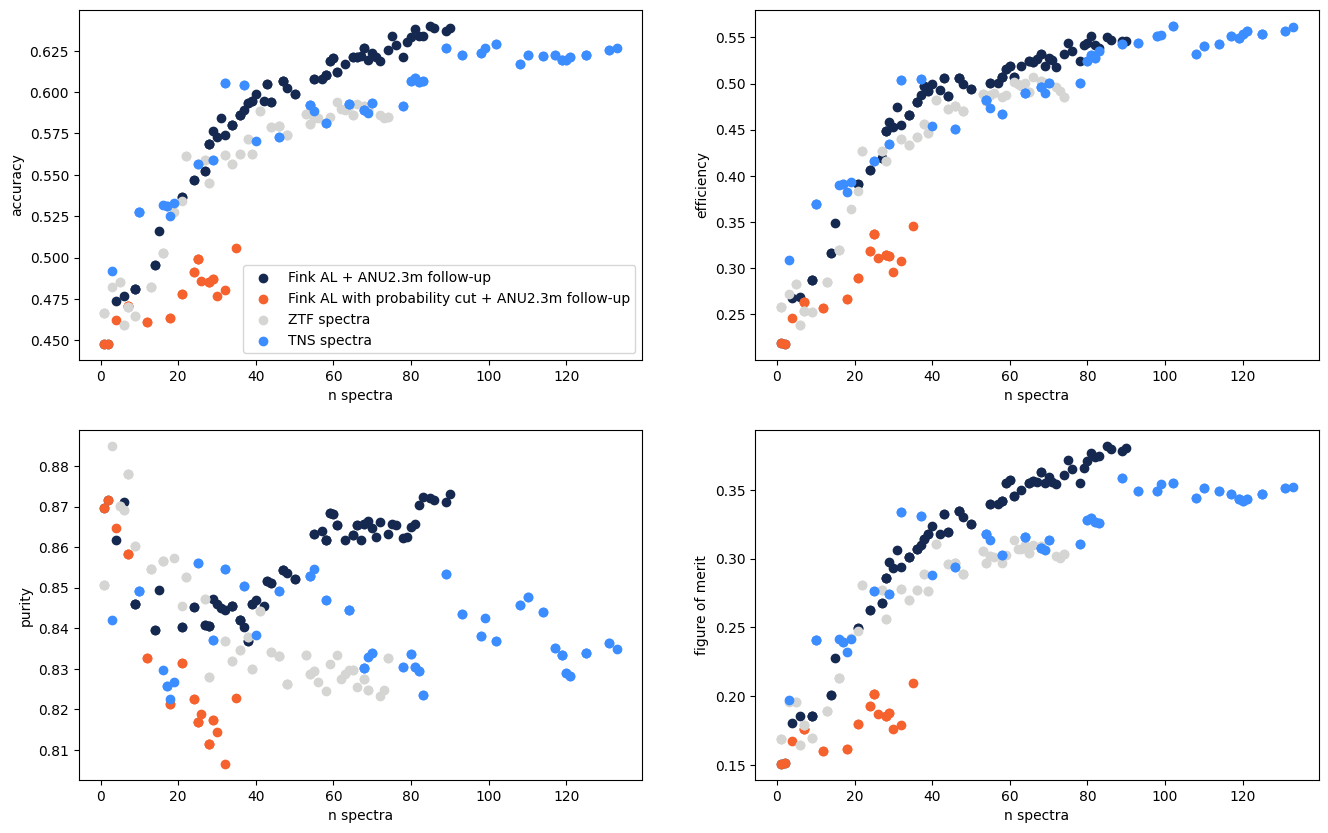

In [57]:
pu.plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf,metrics_allTNS],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra','TNS spectra'],varx='n spectra')

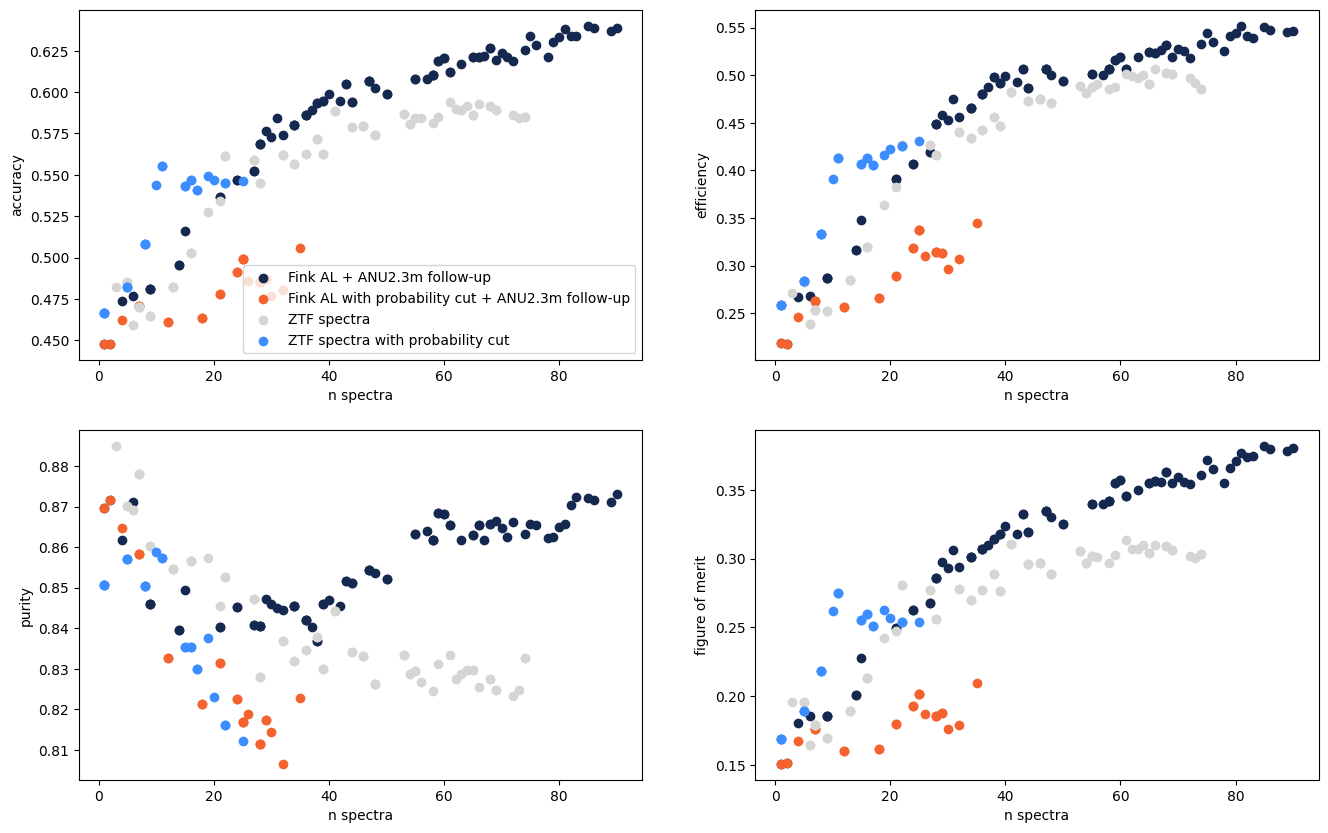

In [53]:
pu.plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf,metrics_ztf_probacut],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra','ZTF spectra with probability cut'],varx='n spectra')

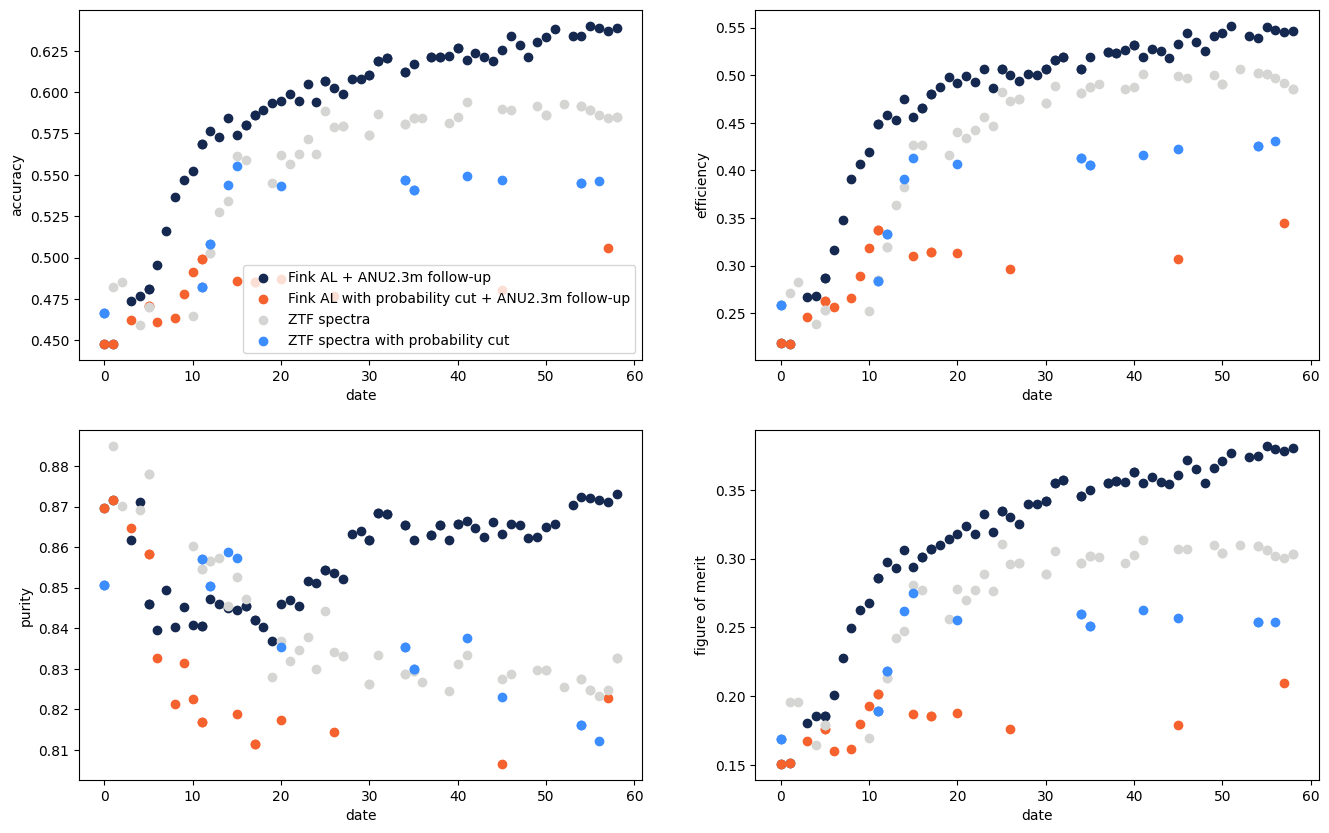

In [24]:
pu.plot_metrics_listdf([metrics_fink_all,metrics_fink_probacut,metrics_ztf,metrics_ztf_probacut],['Fink AL + ANU2.3m follow-up','Fink AL with probability cut + ANU2.3m follow-up','ZTF spectra','ZTF spectra with probability cut'])

In [60]:
df_tns.keys()

Index(['objid', 'name_prefix', 'name', 'ra', 'declination', 'redshift',
       'typeid', 'type', 'reporting_groupid', 'reporting_group',
       'source_groupid', 'source_group', 'discoverydate', 'discoverymag',
       'discmagfilter', 'filter', 'reporters', 'time_received',
       'internal_names', 'Discovery_ADS_bibcode', 'Class_ADS_bibcodes',
       'creationdate', 'lastmodified', 'fullname', 'internalname',
       'discoveryjd', 'type AL', 'discoveryjd+12', 'discoveryjd+12_strfmt'],
      dtype='object')